# Understanding the parameters of Learning With Errors (LWE)

In this report we will briefly explain the Learning with Errors (LWE) method, which is a post-quantum public-key cryptography algorithm. We provide the mathematical background then detail our implementation based on Python 3 and `numpy`, and finally our experiments, whose objective is to understand how changing the parameters of the algorithm affects the expected result. Our experiments are based on the encryption and decryption of a single bit message of value `1`, which are executed ten thousand times for each configuration tested. Graphs are created to visualise the results.

## LWE Decription

LWE is a post-quantum publick-key algorithm, see [this presentation](https://summerschool-croatia.cs.ru.nl/2018/slides/Introduction%20to%20post-quantum%20cryptography%20and%20learning%20with%20errors.pdf) for more information and [the original paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.205.2622&rep=rep1&type=pdf). This method can be resumed to the computations described in this section. First, to create a public and private key:

$$
A_{m}^{n \times 1} \times S_{m}^{1 \times 1} + E_{m}^{n \times 1} = B_{m}^{n \times 1}
$$

$A$ and $B$ are the public key, $S$ is the private key and $E$ is the random error, and $A,B,S,E \in \mathbb{Z}$. The matrixes $A,B,E$ have dimension $n \times 1$, that is, they are single column, because in this report we implement a single-bit encryption and decryption.

To encrypt a single-bit message $x$ using the public key $A,B$ we obtain the encrypted message composed of $(u,v)$ with:

$$
u = \left(\sum A_{samples}\right) \bmod m \\
v = \left(\sum B_{samples}\right) + \frac{q}{2}x \bmod m
$$

Where $samples$ are randomly chosen samples from $A$ and $B$. Finally, to decrypt the message $(u,v)$ and find the value of bit message $x$:

$$
x' = 
\begin{cases}
0 \text{, if } (v - su \bmod m) < \frac{q}{2} \\
1 \text{, else}
\end{cases}
$$

## LWE Implementation

The following `run` function was based on [this material](https://medium.com/asecuritysite-when-bob-met-alice/learning-with-errors-and-ring-learning-with-errors-23516a502406), where LWE is implemented to encrypt and decrypt a single bit of value `1`. All parameters required by the algorithm are passed as parameters for this function. They are:
+ `n` and `m`, where $n$ is the number of rows of the single column matrixes $A,B,E$, and $m$ is the modulo for all the operations
+ `err` sets the largest value of the interval $[1,err] \in \mathbb{Z}$, from which error values are randomly drawn and then added to the result of $A_{m}^{n \times 1} * S_{m}^{1 \times 1}$, as described above
+ `sample` sets the number of samples drawn from the public key $(A,B)$ to encrypt the bit-message `1`
+ `times` sets how many times the experiment is reproduced to find a statistically relevant result

The returned value is in the range $[0,1] \in \mathbb{R}$ and represents how many experiments ran successfully, that is, correctly encrypted and decrypted the bit `1`.

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def run(n = 20, m = 97, err = 4, sample = 5, times = 10000):
    if sample > n: # or m > n:
        return None

    s = np.reshape(np.repeat(n, times), (times, 1))

    A = np.reshape(np.random.choice(range(m), n * times), (times, n))
    e = np.reshape(np.random.randint(1, err + 1, n * times), (times, n))
    B = (A * s + e) % m

    sample = np.reshape(np.random.choice(range(n - 1), sample * times), (times, sample))

    message = 1

    # this [np.arange(times)[:,None], sample] is used for indexing the 2d array
    u = np.sum(A[np.arange(times)[:,None], sample], axis = 1) % m
    v = (np.sum(B[np.arange(times)[:,None], sample], axis = 1) + (m // 2) * message) % m

    s = np.reshape(s, (1, times))

    return np.sum(((v - s * u) % m) > m / 2) / times

## Experiments

Having detailed the mathematical background and how our implementation of LWE works, we now proceed to perform some experiments and discuss their results.

### 1.  Exploring how `n` affects the result

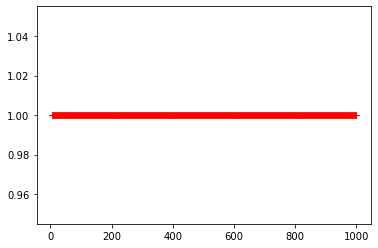

In [33]:
r = list(range(1000))
plt.plot(r, [run(n = i) for i in r], 'r+')
plt.show()

Increasing `n` doesn't affect the correctness of the encryption and decryption processes.

### 2. Exploring how `err` affects the result

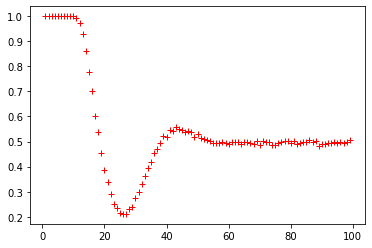

In [29]:
r = list(range(1, 100))
plt.plot(r, [run(err = i) for i in r], 'r+')
plt.show()

Apparently running LWE with the error range uper bound greater than roughly 10% of the modulo `m` affects the correctness of the output. Next, we try a prime modulo of about 10x the current to verify if the 10% threshold holds.

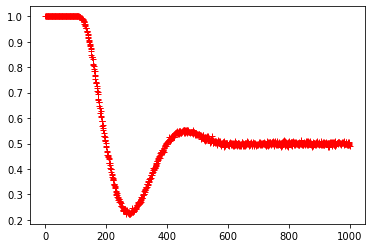

In [28]:
r = list(range(1, 1000))
plt.plot(r, [run(m = 997, err = i) for i in r], 'r+')
plt.show()

That finding is apparently true. Next, let's explore if changing `n` will have any effect. Until now, the experiments ran using `n = 20`

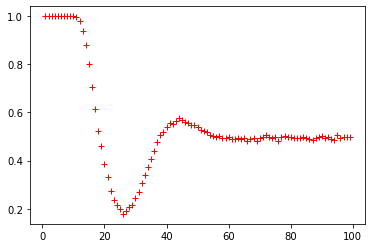

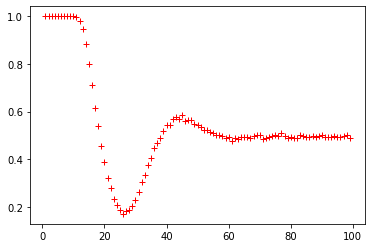

In [27]:
r = list(range(1, 100))

plt.plot(r, [run(n=50, err = i) for i in r], 'r+')
plt.show()

plt.plot(r, [run(n=90, err = i) for i in r], 'r+')
plt.show()

Same behaviour. Now let's change the sampling size.

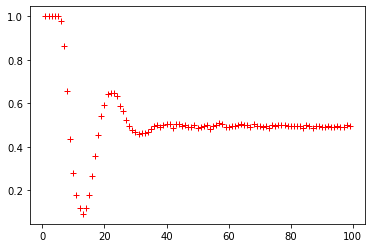

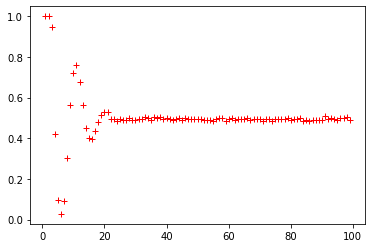

In [31]:
r = list(range(1, 100))

plt.plot(r, [run(sample=10, err = i) for i in r], 'r+')
plt.show()

plt.plot(r, [run(sample=20, err = i) for i in r], 'r+')
plt.show()

Increasing the sample size has an impact! Apparently..
Next, we try with modulo `m = 997` and double the sample on each test to see if the behaviour continues.

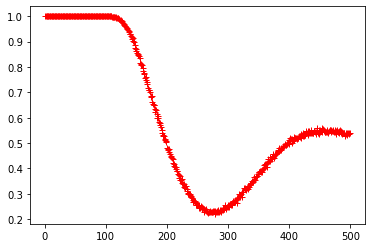

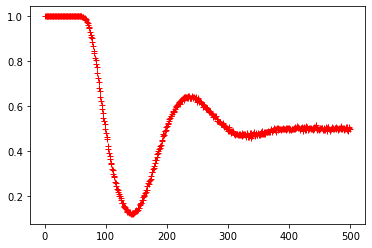

In [34]:
r = list(range(1, 500))

plt.plot(r, [run(sample=5, m = 997, err = i) for i in r], 'r+')
plt.show()

plt.plot(r, [run(sample=10, m = 997, err = i) for i in r], 'r+')
plt.show()

Empircally testing LWE the parameters seem to have to respect the ratio of $err \leq \frac{m}{2 \times sample}$ to correctly encrypt and decrypt. 

Let's put this claim to the test. First we calculate all the prime numbers in the range $[101,100000]$ and select 1 for every 100 primes in the list. Then, for all these primes we select the number of samples at random (limiting at 1% of each prime) and calculate the uper bound value for the error range following the formula $\frac{m}{2 \times sample}$. Next, we run the LWE algorithm with the aforementioned parameters and plot the result. If our empirically found relation holds, then we shall see no point off the `1.0` value in the y axis.

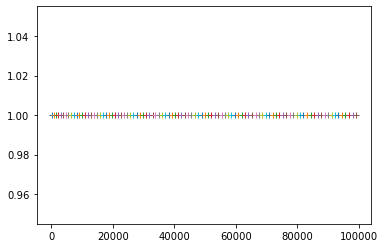

In [91]:
import random

def primes(n):
    """ Returns  a list of primes < n """
    """ https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n/3035188#3035188 """
    sieve = [True] * n
    for i in range(3,int(n**0.5)+1,2):
        if sieve[i]:
            sieve[i*i::2*i]=[False]*((n-i*i-1)//(2*i)+1)
    return [2] + [i for i in range(3,n,2) if sieve[i]]

#primes from 101 to 99991 from 100 to 100
list_of_primes_to_100K = primes(100000)[25:-1:100]

#store our randomly selected sample values
samples = []

#store our calculated error
error_upper_bound = []

for prime in list_of_primes_to_100K:
    #limit sample on 1% of prime (the m parameter)
    s = random.randint(5, max(5, int(prime * .01)))
    samples.append(s)
    
    #calculte the error value based on our find described above
    error = prime // (2 * s)
    
    error_upper_bound.append(error)
    
    #run the tests with the random number of samples and limited errors
    results = [run(n = s, sample = s, m = prime, err = error)]
    
    #plot the results
    plt.plot(prime, results, '+')
plt.show()

No experiment presented any error, our prediction worked well. Next, we use the same values from the last experiment 

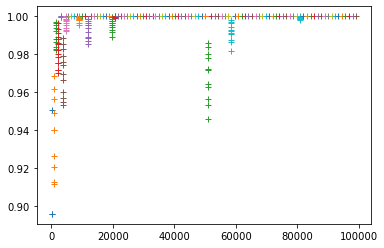

In [88]:
def custom_range(start, stop, increase_percentage):
    while start < stop:
        yield start
        
        if start == int(start*increase_percentage):
            start += 1
        else:
            start *= increase_percentage
            
        start = int(start)
        
    yield int(stop)

for index, prime in enumerate(list_of_primes_to_100K):
    #calculte the error value based on our find described above
    error_upper_bound[index] = [i for i in custom_range(error_upper_bound[index], error_upper_bound[index] * 1.1, 1.01)][::-1]
    
    #run the tests with the random number of samples and limited errors
    results = []
    
    for i in error_upper_bound[index]:
        results.append(run(n = samples[index], sample = samples[index], m = prime, err = i))
        
        if results[-1] == 1.0:
            break
    
    #plot the results
    plt.plot([prime] * len(results), results, '+')

plt.show()

#restore the list error_upper_bound to its previus state
for index, prime in enumerate(list_of_primes_to_1M):
    error_upper_bound[index] = error_upper_bound[index][0]

The relation we found empirically doesn't seem to hold for larger $m$ values. There are probably more complex relations at play in LWE, our equation $err \leq \frac{m}{2 \times sample}$ is a good start, though.